In [1]:
%matplotlib inline
from __future__ import print_function
from simdna import synthetic as sn
import avutils
from avutils import file_processing as fp
import numpy as np
from collections import OrderedDict
import tutorial_utils
from tutorial_utils import viz_sequence_highlight_motifs
from deeplift.blobs import NonlinearMxtsMode, DenseMxtsMode
import deeplift
import deeplift.conversion.keras_conversion as kc
from deeplift.visualization import viz_sequence
import modisco_tutorial

Using gpu device 2: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


# Overview

This tutorial will explore how importance scores from three different importance score methods compare on simulated data.

We simulated sequences to train a model with 3 tasks. The first task represents the presence of both GATA and TAL1 motifs together.  The second task represents the presence of the GATA motif. The third task represents the presence of the TAL1 motif. The simulated data was constructed as follows:
- background sequence had 40% GC content
- 1/4 sequences with 1-3 instances of a GATA_disc1 motif embedded (see http://compbio.mit.edu/encode-motifs/ for the PWM); these were labelled 0,1,0
- 1/4 sequences with 1-3 instances of a TAL1_known1 motif embedded; these were labelled 0,0,1
- 1/4 sequences with BOTH 1-3 instances of a GATA_disc1 motif AND 1-3 instances of a TAL1_known1 motif; these were labelled 1,1,1
- 1/4 sequences with no motif; these were labelled 0,0,0

# Loading the raw data

Load in the testing set of our model for analysis

In [2]:
raw_data = sn.read_simdata_file("sequences.simdata.gz", ids_to_load=fp.read_rows_into_arr("splits/test.txt.gz"))

Let's inspect the contents of the raw_data object.

First, we can access the raw underlying sequence.

In [3]:
raw_data.sequences[:5]

['CTTGTATTGAGTTAGAAACCGCCACGGCACTGCTATGTATGACATTCTAACTAAGTGAGTTATGCGTTGGGTCCTTTATGTGGCATTATCTGGTAATACTTAATTGATGTACTATTTCCTCGACAAAACAGGTGGTGTGGGTGTACCGGTCACCGATAAGGGGGAACTCACCAGATGGTAGTTAACCTATAGAGTCCTGA',
 'TGACAATGGACCCGGTCCGGGTTAGGTACTGATTAGGAACGACCCAGGCCGAGCGACTTATCCCGTTAGATGACGGAATCGTTGTTAGCGGAAAAGAGATAAGAACTTCCCAATTTATACAGATAAGCACACAATGTTTAACGTTCCCGTCTGAGTACTCCTGAATGGGAAGGATATTCTATACTAAGGGATTAGTCGTG',
 'CGTTTGAAAGGAGACCAGGTGGTCCAACCACAGTAGCAGAATATTATGCGGTTGTCGATAGAGCTTTGCTAACAGATGTTTACAGTTATCCTGAAATCGTTTGGACAAACTGTCTTCGTGCGTAATTGCACTGTTATGGCCCAGTACAGGGGATCAGATGGTCATGGCAAAAGGCGTGCCAACGCTCGAACTGGAGTCTT',
 'TATGACGACTGCGTATAGTAGACAGATGGTGGACAATTCCCCGTTACATAAAGGGGTACAGATGGTAAGTCCACAAACCGTAACGGCAACAGATGTTTTGAGGTACAAATATAAGGTCCTGATAAGGAGCCGAGAGCTGACGCGTGCCCAATGAGTACATACGTGATACGAATGCGTGCGCCCGGAGTATGTCAAACCGT',
 'CAGTATCTACTGAAAGGAGAATGCACTTGCCGCAATTAACATCCTCTGATTGCACTTGAGTATTTAACAATATATTATGAGCAAGACGCCGGCCTTGTAAAAGACCAAATATAAGGACAATCTAGGGGCGCGTGACCAAGACTGCATCATATCTTCCAAATTTAGTAGTACGCCGTGG

Then we can access the labels.

In [4]:
print(raw_data.labels[:5])

[[1 1 1]
 [0 1 0]
 [0 0 1]
 [1 1 1]
 [0 0 0]]


We can also access the actual contents of the motif objects that were embedded in the original simulation. Can you verify the relationship between the labels and the embeddings?

In [5]:
print("\n".join(", ".join(str(embedding) for embedding in embeddings_one_seq)
                     for embeddings_one_seq in raw_data.embeddings[:5]))

pos-151_GATA_disc1-ACCGATAAGG, pos-123_TAL1_known1-CAAAACAGGTGGTGTG, pos-166_TAL1_known1-CTCACCAGATGGTAGT
pos-94_GATA_disc1-AGAGATAAGA, pos-118_GATA_disc1-ACAGATAAGC, pos-27_GATA_disc1-ACTGATTAGG
pos-149_TAL1_known1-GGGATCAGATGGTCAT, pos-67_TAL1_known1-GCTAACAGATGTTTAC, pos-10_TAL1_known1-GAGACCAGGTGGTCCA
pos-161_GATA_disc1-CGTGATACGA, pos-117_GATA_disc1-CCTGATAAGG, pos-84_TAL1_known1-GGCAACAGATGTTTTG, pos-53_TAL1_known1-GGGTACAGATGGTAAG, pos-17_TAL1_known1-GTAGACAGATGGTGGA



To train our model we are going to have to one-hot encode the data, which means convert a sequence of bases (e.g. ATGGCA...) to a binary matrix with four rows, representing ACGT, and a column for each base in the sequence:

In [6]:
one_hot_data = avutils.util.one_hot_encode_sequences(raw_data.sequences)

Let's inspect the shape of the one-hot encoded data.

In [7]:
one_hot_data.shape

(800, 1, 4, 200)

The one-hot encoded data has dimensions of sample x channel x row (ACGT) x column (position along sequence). The channel axis always has length 1 in the input layer, but will have a larger length after the convolutional layers (this is the dimension that will store the different convolutional channels).

# PART 1: Importance scores on individual positions

## Make a DeepLIFT model from a Keras model

Let's now set up a DeepLIFT model. In this tutorial, we will start with a Keras model and use the deeplift autoconversion functions to create a DeepLIFT model. Note that it is not necessary to have a keras model; if you have a model trained with a different package, you can write your own conversion scripts to put it in the DeepLIFT format - information on how to do so is documented on the DeepLIFT repo https://github.com/kundajelab/deeplift#under-the-hood. For now, we will stick to the autoconversion.

We will start with loading a Keras model. We're going to load a Keras graph model (version 0.3.2). When we load the model, we need to specify the weights and the configuration. The weights are stored in the .h5 format and the configuration is stored in the .yaml format. We should also specify that the weights of the first conv layer be normalized such that the mean of the weights at any given position sum to 0; this deconvolves the weights and the biases and makes the resulting filters more interpretable. The normalization is output-preserving, so the outputs of the net are identical in both cases. (A bonus problem is to investigate what happens when this normalization is removed.)

In [8]:
keras_model_weights = "model_files/record_1_model_9vvXe_modelWeights.h5"
keras_model_yaml = "model_files/record_1_model_9vvXe_modelYaml.yaml"

keras_model = kc.load_keras_model(weights=keras_model_weights,
                                  yaml=keras_model_yaml,
                                  normalise_conv_for_one_hot_encoded_input=True,
                                  name_of_conv_layer_to_normalise="conv1")

Using Theano backend.
/users/avanti/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


We can inspect the input layers of the keras model as follows:

In [9]:
keras_model.inputs

{'sequence': <keras.layers.core.Layer at 0x7f3930d1d250>}

We can inspect all the intermediate nodes of the model as follows:

In [10]:
keras_model.nodes

OrderedDict([('conv1',
              <keras.layers.convolutional.Convolution2D at 0x7f3930d1d290>),
             ('conv1_act', <keras.layers.core.Activation at 0x7f3930bb3550>),
             ('conv2',
              <keras.layers.convolutional.Convolution2D at 0x7f3930bb3f50>),
             ('conv2_act', <keras.layers.core.Activation at 0x7f3930bbf090>),
             ('avg_pool',
              <keras.layers.convolutional.AveragePooling2D at 0x7f3930bbf310>),
             ('flatten', <keras.layers.core.Flatten at 0x7f3930bbf450>),
             ('dense1', <keras.layers.core.Dense at 0x7f3930bbf490>),
             ('dense1_act', <keras.layers.core.Activation at 0x7f3930c03310>),
             ('dense1_dropout', <keras.layers.core.Dropout at 0x7f3930bbf690>),
             ('output_preact', <keras.layers.core.Dense at 0x7f3930c03410>),
             ('output_act', <keras.layers.core.Activation at 0x7f3930bbfb50>)])

We will now convert the Keras model to the DeepLIFT format using the provided autoconversion functions. We will set the nonlinear multiplier mode to "DeepLIFT" and the dense layer multiplier mode to "Linear." Other variants are explored later in the notebook.

In [11]:
from deeplift.blobs import NonlinearMxtsMode, DenseMxtsMode
deeplift_model = kc.convert_graph_model(model=keras_model,
                                        nonlinear_mxts_mode=NonlinearMxtsMode.DeepLIFT,
                                        dense_mxts_mode=DenseMxtsMode.Linear)

Let's do a sanity check that the conversion happened correctly. We can view the blobs in the converted model as follows (a blob is the equivalent of a layer - we named them 'blobs' to avoid any implication of sequentiality):

In [12]:
deeplift_model.get_name_to_blob()

OrderedDict([('sequence', <deeplift.blobs.core.Input at 0x7f3916135d50>),
             ('conv1', <deeplift.blobs.convolution.Conv2D at 0x7f3916135f90>),
             ('conv1_act',
              <deeplift.blobs.activations.ReLU at 0x7f3916135f50>),
             ('conv2', <deeplift.blobs.convolution.Conv2D at 0x7f3916147050>),
             ('conv2_act',
              <deeplift.blobs.activations.ReLU at 0x7f3916147090>),
             ('avg_pool',
              <deeplift.blobs.convolution.AvgPool2D at 0x7f39161470d0>),
             ('flatten',
              <deeplift.blobs.convolution.Flatten at 0x7f3930eee3d0>),
             ('dense1', <deeplift.blobs.core.Dense at 0x7f3930eee290>),
             ('dense1_act',
              <deeplift.blobs.activations.ReLU at 0x7f3916147110>),
             ('dense1_dropout', <deeplift.blobs.core.NoOp at 0x7f3916147150>),
             ('output_preact', <deeplift.blobs.core.Dense at 0x7f3930d5be10>),
             ('output_act',
              <deeplift.blobs

You can see that most of the keras layers have an equivalent DeepLIFT blob. One exception is the Dropout layer, which maps to a blob object of type "NoOp" ("No Operation"). For those of you familiar with dropout: a dropout layer affects the behaviour of the net while it is training, but does nothing when it's time to make predictions. As deeplift is only applied to models after they are trained, the dropout layer maps to a "NoOp" blob which is the identity function.

### Sanity check the conversion

As a sanity check to make sure the conversion happened correctly, let's define a function to make predictions with this converted deeplift model and verify that it gives the same outputs as the original keras model. We can create a function using get_prediction_fucntion, as shown:

In [13]:
# output_layer_names is a list of the layer that you are getting the outputs of
# input_layer_names is a list of the layers that you are using as inputs to the outputs
deeplift_prediction_function = deeplift_model.get_prediction_function(
    input_layer_names=['sequence'],
    output_layer_name='output_act'
)

# batch_size refers to a batch size for the GPU; predictions are made in batches on the GPU for efficiency
# we retrieve the output at index [0] because we got predictions for just one layer, so the outputs we want
# are at index 0 in the resulting array
deeplift_model_predictions = deeplift_prediction_function([one_hot_data], batch_size=20)

Let's obtain the corresponding predictions from the original keras model

In [14]:
keras_model_predictions = keras_model.predict({'sequence':one_hot_data}, batch_size=20)['output']

Now print out the maximum difference between the two predictions. This should be within numerical accuracy.

In [15]:
print(np.max(np.abs(deeplift_model_predictions - keras_model_predictions)))

0.0


### Get importance scores from the model

This is how we get the function that actually produces importance scores. find_scores_layer_name refers to the layer that we want to find the importance scores for - in this case, the input sequence. pre_activation_target_layer_name refers to the layer that we are computing the contributions to - this should refer to the linear layer prior to the final nonlinearity. We compute the contributions with respect to the linear layer prior to the final sigmoid nonlinearity because, if we computed them with respect to the final layer, the sum of the contributions would be capped at 1 regardless of how confident the example was.

In [16]:
deeplift_scoring_func = deeplift_model.get_target_contribs_func(
                            find_scores_layer_name="sequence",
                            pre_activation_target_layer_name="output_preact")

We can now compute the scores on all the sequences for all three tasks. The first step is to prepare the reference. We will compute the scores with respect to a reference of 40% GC content, which matches the simulation.

In [17]:
GC_array = np.array([0.3, 0.2, 0.2, 0.3]) #positions are A,C,G,T

# [None,None,:,None] refers to the broadcast pattern; one_hot_data
# has dimensions: sample x channel x rows x columns
# the rows are acgt, the columns refer to the position
# along the sequence, and the channel is a dummy axis for the first input layer.
# Thus, we will broadcast over sample, channel and columns.
reference_40GC = np.ones_like(one_hot_data)*GC_array[None,None,:,None]

Let's inspect the reference. Here we look at the first 10 positions of the first two sequences.

In [18]:
print(reference_40GC[0:2, :, :, 0:10])

[[[[ 0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3]
   [ 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2]
   [ 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2]
   [ 0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3]]]


 [[[ 0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3]
   [ 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2]
   [ 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2]
   [ 0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3]]]]


We will now compute the importance scores providing the tasks we are interested in, input data, the reference and the batch size. 

In [19]:
task_to_deeplift_scores_unsummed = OrderedDict()
for task_idx in [0,1,2]:
    task_to_deeplift_scores_unsummed[task_idx] = np.array(deeplift_scoring_func(
                                                task_idx=task_idx,
                                                input_data_list=[one_hot_data],
                                                input_references_list=[reference_40GC],
                                                batch_size=20,
                                                # if you pass an integer for progress_update, you will get
                                                # a message printed every time that number of items is processed
                                                progress_update=None))

Aside: it would also have worked to provide GC_array[None,None,:,None] as the reference, because the broadcast would have been done automatically so that the reference had the same dimensions as the input. The advantage of having a reference with the same dimensions as the input is that it's possible to have a different reference for each individual sample in the input.

Let's inspect the resulting scores array for a particular task:

In [20]:
print("Shape: ",str(task_to_deeplift_scores_unsummed[0].shape))
print(task_to_deeplift_scores_unsummed[0][0][0][:,0:3])

Shape:  (800, 1, 4, 200)
[[ -5.45780233e-04  -2.73494952e-04  -9.68668319e-05]
 [ -2.50843051e-03   1.40580305e-04   5.97342558e-04]
 [ -5.65681199e-04   2.40816575e-04  -1.20232817e-05]
 [  4.53640678e-04   6.96734118e-04   1.82259583e-03]]


We see that the importance scores have the same dimensions as the input. Question: why are scores on all four positions of A,C,G,T nonzero, even though the input is one-hot-encoded (meaning at most one of those positions can be nonzero in the input)? (Hint: what is the reference?)

Let's sum over ACGT at each position (so that we get a sense of the total contribution of each position), and let's also get rid of the channel axis as it's a dummy axis:

In [21]:
task_to_deeplift_scores = OrderedDict()
for task in task_to_deeplift_scores_unsummed:
    task_to_deeplift_scores[task] = np.squeeze(np.sum(task_to_deeplift_scores_unsummed[task],axis=2),axis=1)

### Visualize scores on a sequence

We can now visualize the DeepLIFT scores of an individual sequence. In the visualization, the blue boxes indicate the true locations of embedded GATA motifs, and the green boxes indicate true locations of embedded TAL1 motifs.

Visualizing task 0


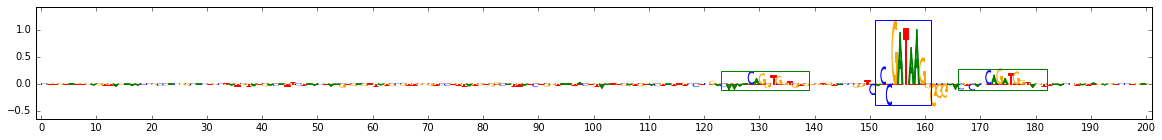

Visualizing task 1


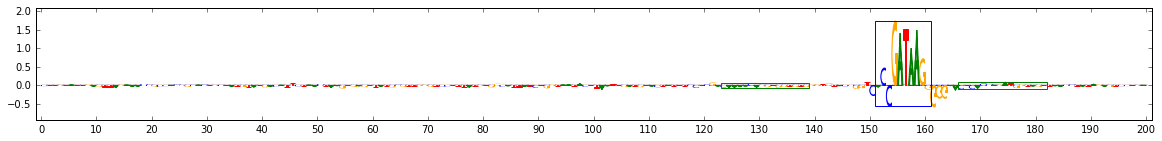

Visualizing task 2


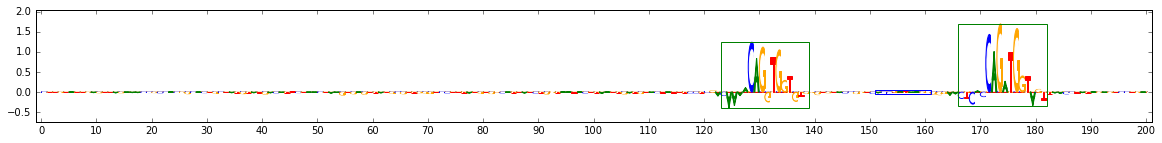

In [22]:
idx=0
for task in task_to_deeplift_scores:
    print("Visualizing task",task)
    viz_sequence_highlight_motifs(task_to_deeplift_scores[task][idx], one_hot_data[idx], raw_data.embeddings[idx])

## A different variant of DeepLIFT

The highlighting of the TAL1 motifs in the example above for task 0 may be dissatisfying. It turns out that the behaviour of the algorithm can be improved by setting dense_mxts_mode to DenseMxtsMode.Counterbalance. We will create a model for the counterbalance scores and evaluate its performance on the sequence above. We now need to get the scores from this model. To make things easier this time, we shall define the following convenience functions:

In [23]:
def get_scores_given_scoring_func(scoring_func, one_hot_data, reference, task_idx):
    return np.squeeze(
            np.sum(
                np.array(scoring_func(
                    task_idx=task_idx,
                    input_data_list=[one_hot_data],
                    input_references_list=[reference],
                    batch_size=20,
                    progress_update=None)),
                axis=2),
            axis=1)

def viz_scores_for_tasks(seq_idx, task_to_scores, one_hot_data, embeddings):
    print("Visualizing index",seq_idx)
    for task_idx in task_to_scores:
        print("Task",task_idx)
        viz_sequence_highlight_motifs(
            task_to_scores[task_idx][seq_idx],
            one_hot_data[seq_idx],
            embeddings[idx])

Let's obtain and visualize the scores of the counterbalance model on the same sequence.

Visualizing index 0
Task 0


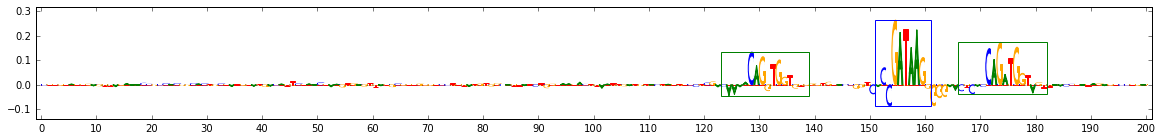

Task 1


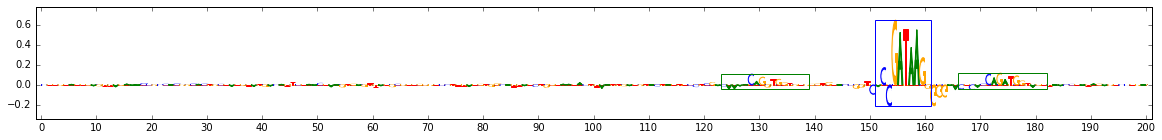

Task 2


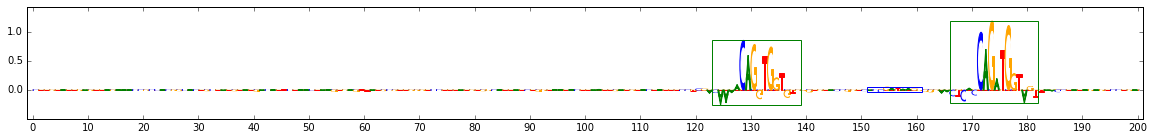

In [24]:
counterbalance_deeplift_model =  kc.convert_graph_model(model=keras_model,
                                        nonlinear_mxts_mode=NonlinearMxtsMode.DeepLIFT,
                                        dense_mxts_mode=DenseMxtsMode.Counterbalance)
counterbalance_scoring_func = counterbalance_deeplift_model.get_target_contribs_func(
                                find_scores_layer_name="sequence",
                                pre_activation_target_layer_name="output_preact")

task_to_counterbalance_deeplift_scores = OrderedDict()
for task_idx in [0,1,2]:
    task_to_counterbalance_deeplift_scores[task_idx] = get_scores_given_scoring_func(
                        scoring_func=counterbalance_scoring_func,
                        one_hot_data=one_hot_data,
                        reference=reference_40GC,
                        task_idx=task_idx)
    
viz_scores_for_tasks(seq_idx=0,
                     task_to_scores=task_to_counterbalance_deeplift_scores,
                     one_hot_data=one_hot_data,
                     embeddings=raw_data.embeddings)

What do you think of the relative merits of the two methods?

## Comparing various methods

We can go through and define a whole host of different scoring models. Let's compile a bunch of different scoring functions. Fill in the interiors of the loops below.

In [ ]:
method_to_scoring_func = OrderedDict()
for method_name, nonlinear_mxts_mode, dense_mxts_mode in [
    ('deeplift', NonlinearMxtsMode.DeepLIFT, DenseMxtsMode.Linear),
    ('counterbalance_deeplift', NonlinearMxtsMode.DeepLIFT, DenseMxtsMode.Counterbalance),
    ('gradient', NonlinearMxtsMode.Gradient, DenseMxtsMode.Linear),
    ('counterbalance_gradient', NonlinearMxtsMode.Gradient, DenseMxtsMode.Counterbalance),
    ('guided_backprop', NonlinearMxtsMode.GuidedBackprop, DenseMxtsMode.Linear),
    ('guided_backprop_deeplift', NonlinearMxtsMode.GuidedBackpropDeepLIFT, DenseMxtsMode.Linear),
]:
    print("Prepping scoring function for",method_name)
    model = #fill me in!
    scoring_func = #fill me in!
    method_to_scoring_func[method_name] = scoring_func

method_to_task_to_scores = OrderedDict()
for method_name in method_to_scoring_func:
    print("Computing scores for",method_name)
    scoring_func = method_to_scoring_func[method_name]
    task_to_scores = OrderedDict()
    for task_idx in [0,1,2]:
        task_to_scores[task_idx] = #fill me in!
    method_to_task_to_scores[method_name] = task_to_scores

In [28]:
###
# ANSWER HERE! DON'T LOOK UNLESS YOU ARE STUCK!
###

method_to_scoring_func = OrderedDict()
for method_name, nonlinear_mxts_mode, dense_mxts_mode in [
    ('deeplift', NonlinearMxtsMode.DeepLIFT, DenseMxtsMode.Linear),
    ('counterbalance_deeplift', NonlinearMxtsMode.DeepLIFT, DenseMxtsMode.Counterbalance),
    ('gradient', NonlinearMxtsMode.Gradient, DenseMxtsMode.Linear),
    ('counterbalance_gradient', NonlinearMxtsMode.Gradient, DenseMxtsMode.Counterbalance),
    ('guided_backprop', NonlinearMxtsMode.GuidedBackprop, DenseMxtsMode.Linear),
    ('guided_backprop_deeplift', NonlinearMxtsMode.GuidedBackpropDeepLIFT, DenseMxtsMode.Linear),
]:
    print("Prepping scoring function for",method_name)
    model = kc.convert_graph_model(
                model=keras_model,
                nonlinear_mxts_mode=nonlinear_mxts_mode,
                dense_mxts_mode=dense_mxts_mode)
    scoring_func = model.get_target_contribs_func(
                        find_scores_layer_name="sequence",
                        pre_activation_target_layer_name="output_preact")
    method_to_scoring_func[method_name] = scoring_func

method_to_task_to_scores = OrderedDict()
for method_name in method_to_scoring_func:
    print("Computing scores for",method_name)
    scoring_func = method_to_scoring_func[method_name]
    task_to_scores = OrderedDict()
    for task_idx in [0,1,2]:
        task_to_scores[task_idx] = get_scores_given_scoring_func(
                                    scoring_func=scoring_func,
                                    one_hot_data=one_hot_data,
                                    reference=reference_40GC,
                                    task_idx=task_idx)
    method_to_task_to_scores[method_name] = task_to_scores

Prepping scoring function for deeplift
Prepping scoring function for counterbalance_deeplift
Prepping scoring function for gradient
Prepping scoring function for counterbalance_gradient
Prepping scoring function for guided_backprop
Prepping scoring function for guided_backprop_deeplift
Computing scores for deeplift
Computing scores for counterbalance_deeplift
Computing scores for gradient
Computing scores for counterbalance_gradient
Computing scores for guided_backprop
Computing scores for guided_backprop_deeplift


To help with comparing scores, we define the following convenience function

In [29]:
def viz_scores_for_methods(seq_idx, task_idx):
    print("Visualizing index",seq_idx,"for task",task_idx)
    for method_name in method_to_task_to_scores:
        print("Method",method_name)
        viz_sequence_highlight_motifs(
            method_to_task_to_scores[method_name][task_idx][seq_idx],
            one_hot_data[seq_idx],
            raw_data.embeddings[seq_idx])

Now explore scores on different sequences!

Visualizing index 0 for task 0
Method deeplift


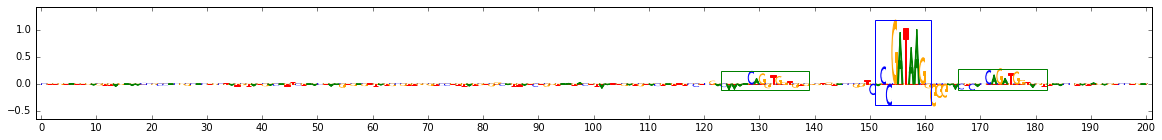

Method counterbalance_deeplift


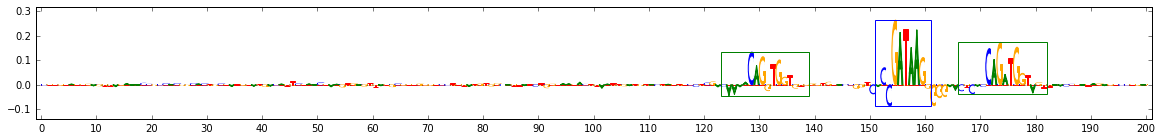

Method gradient


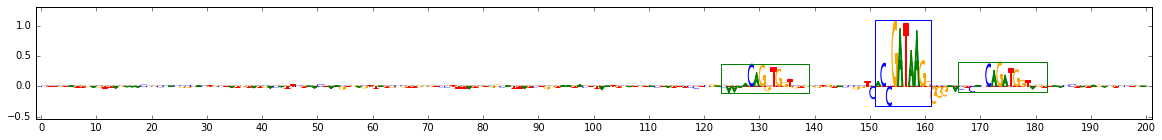

Method counterbalance_gradient


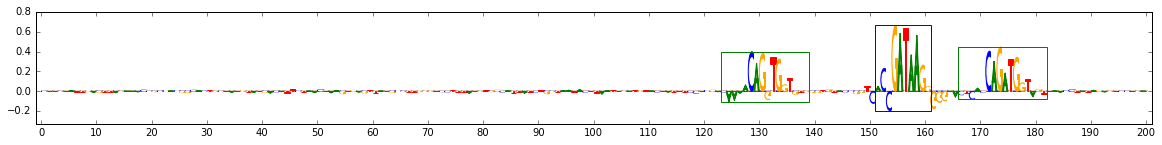

Method guided_backprop


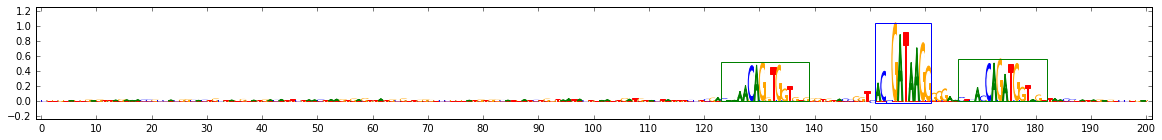

Method guided_backprop_deeplift


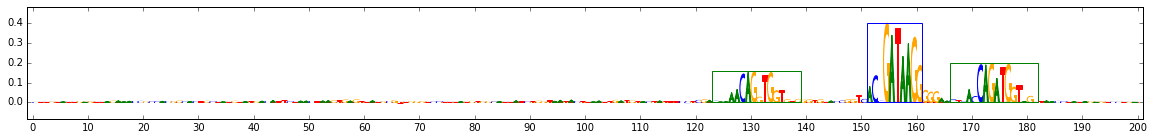

In [30]:
viz_scores_for_methods(seq_idx=0, task_idx=0)

Here are some additional suggestions to try. Remember, task 0 is "both GATA and TAL", task 1 is "GATA only", task 2 is "TAL only". Also pay attention to the scale of values on the left. Although the scale is different from method to method, differences in scale for the same method are meaningful.

- seq_idx 248 (a sequence with only GATA motifs), tasks 0, 1 and 2. In particular, pay attention to what guided backprop does on the TAL-only task. Also note the scale for the non-guided-backprop methods for task 0.
- seq_idx 199 (a sequence with only TAL motifs), tasks 0, 1 and 2. In particular, pay attention to what guided backprop does on the GATA-only task. Also note the scale for the non-guided-backprop methods for task 0.
- seq idx 624, task 1 scores. Pay attention to the difference between the deeplift vs. non-deeplift variants.
- seq idx 123, task 0 scores. Observe the difference between the original and the counterbalance.

In [ ]:
viz_scores_for_methods(seq_idx=, task_idx=)

## Calling motif hits

One way to call motif hits is to use sliding windows of a certain size. We can smooth our importance scores using this sliding window and take top 5 windows per sequence. We can then compare those scores to the true locations as extracted by the compile_motif_locations function computes from our embedding. Let's investigate the recall at different FDRs that we can obtain with this approach. We will define the following convenience function:

In [31]:
def print_recalls_at_fdrs_GATA_and_TAL(scoring_func,
                                       one_hot_data,
                                       reference,
                                       embeddings,
                                       fdr_thresholds=[0.5, 0.2, 0.1, 0.05, 0.01],
                                       window_size=10):
    scores_gata_only, scores_tal_only = [get_scores_given_scoring_func(
                                            scoring_func=scoring_func,
                                            one_hot_data=one_hot_data,
                                            reference=reference,
                                            task_idx=task_idx) for task_idx in [1,2]]
    gata_locations = tutorial_utils.compile_motif_locations('GATA_disc1', embeddings)
    tal_locations = tutorial_utils.compile_motif_locations('TAL1_known1', embeddings)
    
    for task_name, scores, motif_locations in [
        ('gata_only', scores_gata_only, gata_locations),
        ('tal_only', scores_tal_only, tal_locations)]:
        print("On",task_name)    
        recalls_at_fdrs = tutorial_utils.compute_recall_at_fdrs(
                                scores=scores,
                                window_size=window_size,
                                motif_locations=motif_locations,
                                fdr_thresholds=fdr_thresholds
                            )    
        print("Recalls at different fdrs:")
        print("\n".join(str(fdr)+"\t"+str(recall) for fdr,recall in recalls_at_fdrs.items()))

The recall-at-fdr for the different methods is shown below.

In [32]:
for method in ['deeplift','gradient']:
    print("On method",method)
    print_recalls_at_fdrs_GATA_and_TAL(
        scoring_func=method_to_scoring_func[method],
        one_hot_data=one_hot_data,
        reference=reference_40GC,
        embeddings=raw_data.embeddings
    )

On method deeplift
On gata_only
Recalls at different fdrs:
0.5	0.916312056738
0.2	0.726241134752
0.1	0.68085106383
0.05	0.490780141844
0.01	0.0283687943262
On tal_only
Recalls at different fdrs:
0.5	0.97386519945
0.2	0.861072902338
0.1	0.773039889959
0.05	0.0577716643741
0.01	0.0123796423659
On method gradient
On gata_only
Recalls at different fdrs:
0.5	0.90780141844
0.2	0.703546099291
0.1	0.0156028368794
0.05	0.00709219858156
0.01	0.00709219858156
On tal_only
Recalls at different fdrs:
0.5	0.983493810179
0.2	0.92984869326
0.1	0.00137551581843
0.05	0.00137551581843
0.01	0.00137551581843


## Importance of the reference

What happens if we change the reference? Find the recalls at different FDRs using a reference of 50% GC content.

In [40]:
reference_50GC = # fill me in

###
# ANSWER BELOW! DON'T LOOK TILL YOU HAVE TRIED YOURSELF
###
#
#
#
# reference_50GC = np.ones_like(one_hot_data)*np.array([0.25, 0.25, 0.25, 0.25])[None,None,:,None]

for method in ['deeplift','gradient']:
    print("On method",method)
    print_recalls_at_fdrs_GATA_and_TAL(
        scoring_func=method_to_scoring_func[method],
        one_hot_data=one_hot_data,
        reference=reference_50GC,
        embeddings=raw_data.embeddings
    )

On method deeplift
On gata_only
Recalls at different fdrs:
0.5	0.912056737589
0.2	0.675177304965
0.1	0.460992907801
0.05	0.0992907801418
0.01	0.0539007092199
On tal_only
Recalls at different fdrs:
0.5	0.980742778542
0.2	0.867950481431
0.1	0.781292984869
0.05	0.0275103163686
0.01	0.019257221458
On method gradient
On gata_only
Recalls at different fdrs:
0.5	0.906382978723
0.2	0.022695035461
0.1	0.0156028368794
0.05	0.00851063829787
0.01	0.00851063829787
On tal_only
Recalls at different fdrs:
0.5	0.983493810179
0.2	0.938101788171
0.1	0.00275103163686
0.05	0.00275103163686
0.01	0.00275103163686


# Part 2: Motif discovery

We start by getting the positive set for task 0.

In [83]:
task_idx = 0
model_to_use = counterbalance_deeplift_model
one_hot_data_positives = np.array([one_hot for one_hot,labels in
                            zip(one_hot_data, raw_data.labels) if labels[task]==1])
modisco_reference = np.array([0.3, 0.2, 0.2, 0.3])[None,None,:,None]

## Visualize the top-scoring filters

Now, let's try visualizing the top convolutional filters. We start by computing the scores on the first convolutional layer. Fill in the argument to find_scores_layer_name. To help you out, we have reprinted the names of all the blobs below.

In [84]:
model_to_use.get_name_to_blob().keys()

['sequence',
 'conv1',
 'conv1_act',
 'conv2',
 'conv2_act',
 'avg_pool',
 'flatten',
 'dense1',
 'dense1_act',
 'dense1_dropout',
 'output_preact',
 'output_act']

In [85]:
conv_layer_contribs_func = model_to_use.get_target_contribs_func(
                            find_scores_layer_name='conv1',#what should you put here?
                            pre_activation_target_layer_name="output_preact")
conv_layer_contribs = np.array(conv_layer_contribs_func(
                                task_idx=task_idx,
                                input_data_list=[one_hot_data_positives],
                                input_references_list=[modisco_reference],
                                batch_size=200, progress_update=None))

Let's now histogram the scores across all the channels:

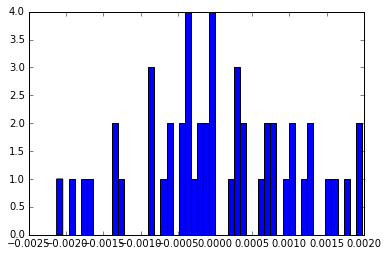

In [86]:
per_channel_scores = np.mean(np.squeeze(conv_layer_contribs), axis=(-1,0))
import matplotlib.pyplot as plt
hist = plt.hist(per_channel_scores, bins=50)
plt.show()

Let's visualize individual convolutional filters. We can obtain the weights of the filters and biases as shown below

In [87]:
# Get the actual weights and biases
conv_weights, conv_biases = model_to_use.get_name_to_blob()['conv1'].W,\
                                    model_to_use.get_name_to_blob()['conv1'].b
# The shape of the weights is:
# number of filters x number of input channels x kernel height (tgca) x filter length
print("conv_weights shape",conv_weights.shape)
# There is one bias per filter.
print("conv_biases shape",conv_biases.shape)

conv_weights shape (50, 1, 4, 11)
conv_biases shape (50,)


Note that convolutions scan the reversed sequence (if they scanned the forward sequence, they would be called cross-correlation). Thus, if there are patterns on the convolution filters, they lie on the reverse complement strand. Normally this doesn't matter as the reverse-complemented pattern occurs as often as the forward-complemented pattern, but because this is simulated data, we did not reverse-complement the patterns for ease of interpretabiility. We will thus reverse complement the weights along the last two dimensions (which see the sequence).

In [88]:
conv_weights = conv_weights[:,:,::-1,::-1]

Now we are ready to visualize the weights.

importance: 0.00197628 bias: -1.21735


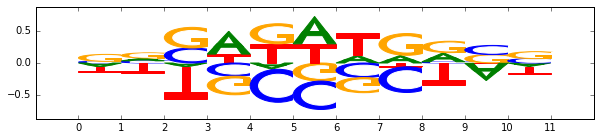

importance: 0.00189655 bias: -0.657478


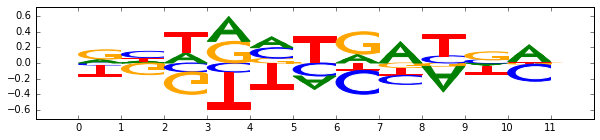

importance: 0.00176496 bias: -1.0561


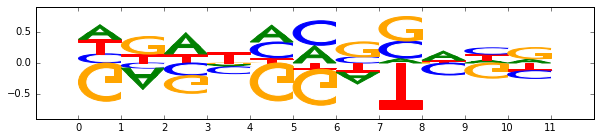

importance: 0.00162088 bias: -2.95436


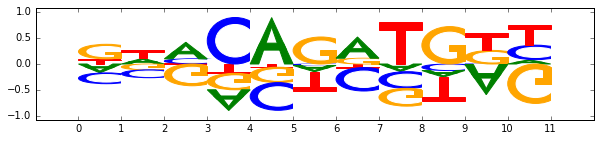

importance: 0.00148908 bias: -0.576213


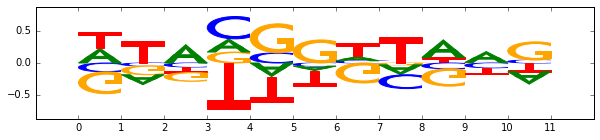

In [89]:
# Sort channels in descending order of importance
channels_sorted_by_importance = sorted(
    zip(conv_weights, conv_biases, per_channel_scores),
    key=lambda x: -x[2])

# Plot the weights of the top channels
for i in range(0,5):
    this_filter_bias = channels_sorted_by_importance[i][1]
    this_filter_weights = channels_sorted_by_importance[i][0][0]
    this_filter_importance = channels_sorted_by_importance[i][2]
    # Normalize the weights so that each position effectively 
    print("importance: "+str(this_filter_importance)+" bias: "+str(this_filter_bias))
    viz_sequence.plot_weights(this_filter_weights, figsize=(10,2))

## Consolidating the patterns

One of the patterns - CAGATG, is visible from looking at individual filters above, but the second pattern - GATA - is not so apparent. Can we extract the more consolidated pattern? This is where MoDISco comes in.

### Compute sequence-level importance

We start by computing the importance scores on the sequence

In [90]:
sequence_contribs_func = model_to_use.get_target_contribs_func(
                                    find_scores_layer_name='sequence',
                                    pre_activation_target_layer_name='output_preact')
sequence_contribs = np.array(
                        sequence_contribs_func(task_idx=task_idx,
                            input_data_list=[one_hot_data_positives],
                            input_references_list=[modisco_reference],
                            batch_size=20, progress_update=None))

Once again, let's inspect the importance scores

In [91]:
print("Shape:",sequence_contribs.shape)
print(sequence_contribs[0,:,:,0:3])

Shape: (424, 1, 4, 200)
[[[ -1.27095118e-04   2.00718205e-05   5.56804298e-05]
  [ -5.51667355e-04  -1.36268745e-05   6.19301886e-07]
  [ -1.27116262e-04   8.55827238e-05   1.26477578e-04]
  [  1.10894260e-04   2.98679719e-04   5.74760023e-04]]]


As mentioned before, because of our choice of reference, we have importance scores on all four bases at each position even though only one base is present per position in the actual one-hot encoded sequence. This can be confusing, so for ease of interpretation we will move all of the importance onto the base that is actually present at a given position.

In [92]:
sequence_contribs = np.sum(sequence_contribs,axis=-2)[:,:,None,:]*one_hot_data_positives
print("Shape: ",sequence_contribs.shape)
print(sequence_contribs[0,:,:,0:3])

Shape:  (424, 1, 4, 200)
[[[-0.          0.          0.        ]
  [-0.00069498  0.          0.        ]
  [-0.          0.          0.        ]
  [-0.          0.00039071  0.00075754]]]


### Identify high-scoring segments

Let's now identify high-scoring segments, dubbed "seqlets." In order to identify these seqlets we specify a few parameters including the size of the seqlet, the amount of flanking sequence to consider, the minimum distance between our discovered seqlets, the minimal magnitude of importance scores relative to the most important (anything less than that ratio is not identified as a seqlet), and the total number of seqlets.

In [93]:
segment_identifier = modisco_tutorial.FixedWindowAroundPeaks(
                                        sliding_window_for_max_size=7,
                                        flank_to_expand_around_peak_size=3,
                                        exclude_peaks_within_window=7,
                                        ratio_to_top_peaks_to_include=0.3,
                                        max_segments=6)
seqlets, seqlet_indices = modisco_tutorial.get_seqlets(
                            raw_importance_contribs=sequence_contribs,
                            segment_identifier=segment_identifier,
                            rev_comp_func=modisco_tutorial.dna_rev_comp_func)

# Filter out any shorter seqlets from the edges of sequences
seqlets = modisco_tutorial.filter_shorter_seqlets(seqlets)

print("Total seqlets:",len(seqlets))

Done 0 of 424
Done 100 of 424
Done 200 of 424
Done 300 of 424
Done 400 of 424
Total seqlets: 968


### Augment with multiplier information

Our seqlets were identified using the importance-score track, but having identified the seqlets we can now add information from any other data track. For instance, we are going to add in information about the multipliers, as this will aid with clustering. The first step is to compute the multipliers on the sequence, which we do below.

In [94]:
sequence_multipliers_func = model_to_use.get_target_multipliers_func(
                                        find_scores_layer_name='sequence',
                                        pre_activation_target_layer_name='output_preact')
sequence_multipliers = np.array(sequence_multipliers_func(task_idx=task_idx,
                                input_data_list=[one_hot_data_positives],
                                input_references_list=[modisco_reference],
                                batch_size=20, progress_update=None))

The augmentation is done below. In addition to augmenting the seqlets with the multiplier informaiton, we also augment them with the original one-hot encoded seqlets.

In [95]:
# Augment tracks
for (full_data_arr,
     name,
     pseudocount) in [
       (np.squeeze(one_hot_data_positives, axis=1).astype("float"),
        "sequence",
        0.25 #pseudocount
        # Pseudocounts are useful when seqlets are merged
        # into a motif (later), but we don't want to be
        # overconfident in the frequency of bases at any
        # particular position. 0.25 means that each
        # 'pseudocount' at a particular position carries
        # a value of 0.25       
       ),
       (np.squeeze(sequence_multipliers, axis=1), #data
        "sequence_multipliers",
        0.0)]:
    modisco_tutorial.augment_seqlets_with_data(
        seqlets,
        full_data_arr=full_data_arr,
        key_name=name,
        pseudocount=pseudocount,
        rev_comp_func=modisco_tutorial.dna_rev_comp_func)

Let's visually explore some of the seqlets to sanity-check that the augmentation happened as expected. The seqlets are sorted in order of total importance. Let's view a couple.

Seqlet with idx 2
Track: sequence


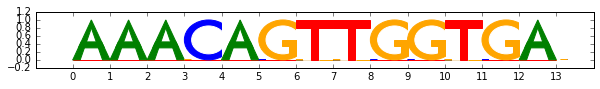

Track: core_importance_track


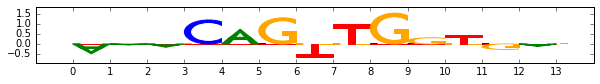

Track: sequence_multipliers


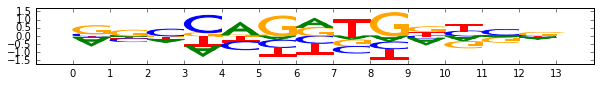

Seqlet with idx 60
Track: sequence


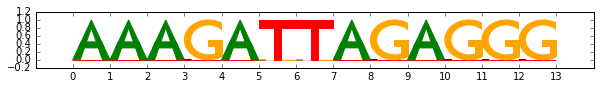

Track: core_importance_track


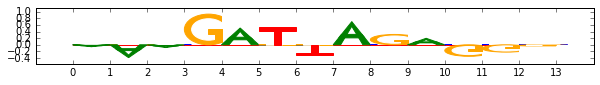

Track: sequence_multipliers


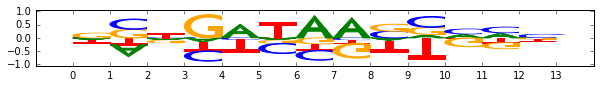

In [102]:
# Visually explore some seqlets as a sanity check
track_names_to_print=["sequence", "core_importance_track", "sequence_multipliers"]
for idx in [2,60]:
    print("Seqlet with idx",idx)
    for track_name in track_names_to_print:
        print("Track:",track_name)
        viz_sequence.plot_weights(seqlets[idx].get_summed_data_track(track_name),
                                  figsize=(10,1))

Note how for the second seqlet above, the multipliers reveal that the net was hoping for an "A" in the middle of "CAGATG", even though it actually saw a "C" - in this way, the multipliers can act like an "autocomplete".

### Cluster by similarity

Now that we have the seqlets, let's compute a pairwise correlation matrix between them.

In [103]:
seqlets_corr_mat = modisco_tutorial.get_correlation_matrix(
    seqlets,
    # Use the mutlipliers to do the correlation
    subtracks_to_align_on=["sequence_multipliers"],
    # In this simulated data, there are no reverse complements - however,
    # in general it is important to account for the reverse complement
    # when computing the distance matrix, so we leave this at True
    account_for_rev_comp=True,
    batch_size=20)

Num words: 968 and 968
On filters 0 to 968
Done 0
Repeating for reverse complement
On filters 0 to 968
Done 0
Seconds to compute corr mat: 2.7510740757


We then use t-sne to identify similar seqlets in the same cluster based on the distance matrix we just computed. First we create a t-sne embedding.

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 968 / 968
[t-SNE] Mean sigma: 0.120789
[t-SNE] Iteration 25: error = 1.1177640, gradient norm = 0.0105318
[t-SNE] Iteration 50: error = 1.0527976, gradient norm = 0.0121035
[t-SNE] Iteration 75: error = 0.7926907, gradient norm = 0.0041723
[t-SNE] Iteration 100: error = 0.7929723, gradient norm = 0.0072465
[t-SNE] Error after 100 iterations with early exaggeration: 0.792972
[t-SNE] Iteration 125: error = 0.7226237, gradient norm = 0.0025714
[t-SNE] Iteration 150: error = 0.7225125, gradient norm = 0.0047600
[t-SNE] Iteration 175: error = 0.7364046, gradient norm = 0.0054835
[t-SNE] Iteration 200: error = 0.7411392, gradient norm = 0.0061655
[t-SNE] Iteration 200: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 200 iterations: 0.741139


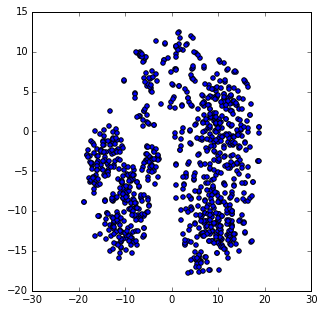

In [104]:
# Find the t-sne embedding using the distance metric
np.random.seed(1234)
embedding_corr = modisco_tutorial.get_tsne_embedding_of_modisco_motifs(
                    seqlets_corr_mat, perplexity=50, verbose=2)
modisco_tutorial.scatter_plot(embedding_corr)

Then we cluster the t-sne embedding by k-means.

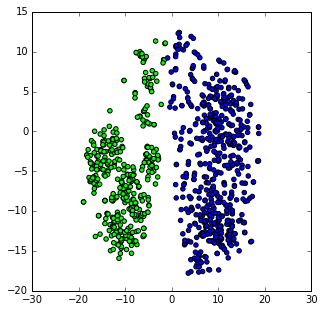

In [105]:
import sklearn.cluster
kmeans_clusters = sklearn.cluster.KMeans(n_clusters=2, n_init=10).fit_predict(embedding_corr)
modisco_tutorial.scatter_plot(embedding_corr, labels=kmeans_clusters)

### Aggregate within clusters

Within each cluster, we then align seqlets by their multipliers and aggregate.

In [106]:
merged_motifs = modisco_tutorial.create_merged_modisco_motifs(
                    kmeans_clusters, seqlets,
                    subtracks_to_align_on=["sequence_multipliers"],
                    account_for_rev_comp=True)

We trim to positions that at least 50% of the seqlets align to.

In [107]:
trimming_func = modisco_tutorial.TrimArrayColumnsToNumUnderlyingObs(0.5)
merged_motifs = modisco_tutorial.adjust_modisco_motifs_using_trimming_criterion(
                    merged_motifs,
                    trimming_func=trimming_func)

We can then visualize the motifs that we have created from this process. We recreate the GATA and TAL1 motifs that were embedded!

On motif 0


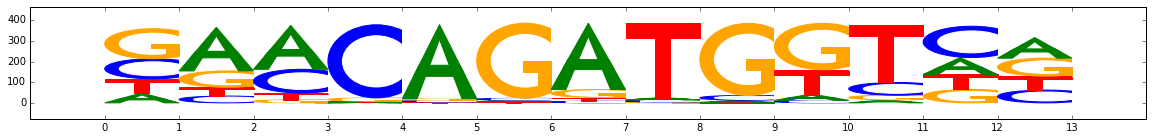

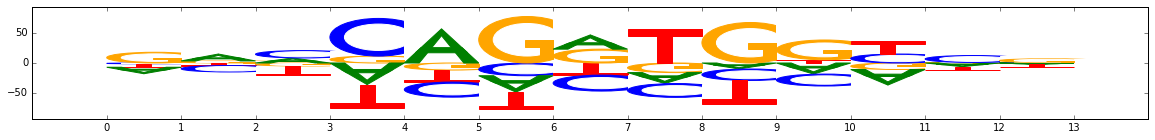

On motif 1


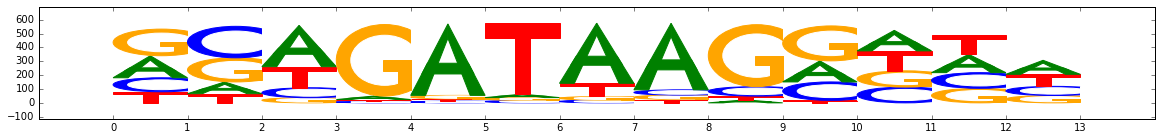

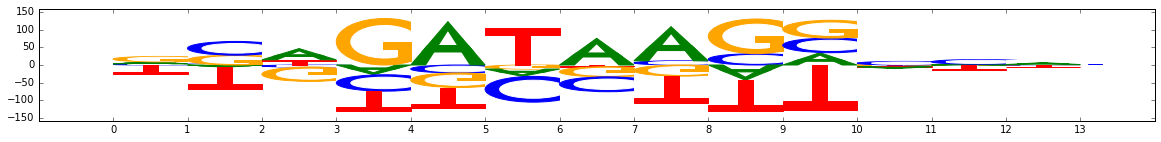

In [108]:
for motif_idx, motif in enumerate(merged_motifs.values()):
    print("On motif",motif_idx)
    for track_name in ["sequence", "sequence_multipliers"]:
        viz_sequence.plot_weights(
            motif.get_summed_data_track(track_name),
            figsize=(20,2))